In [1]:
# import packages and define functions
import cartopy 
import cartopy.crs as ccrs
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage as snd
from scipy.ndimage.measurements import label
import warnings
warnings.filterwarnings('ignore')
import random
import xarray as xr

# following the defition from Demortier, A., Bozkurt, D., & Jacques-Coper, M. (2021).
# Identifying key driving mechanisms of heat waves in central Chile.
# Climate Dynamics, 57(9), 2415-2432.
# takes daily max temperature time series, and the 90th percentile value 
# must separate data by season on your own
# returns an time series the same size as the temperature data but with a label for each unique 
# HW at if there is a HW at that time, for example: [0 0 0 1 1 1 0 0 0 2 2 2 2 0]
# means there was no HW for the first three days, then a heat wave for 3 days, then 3 days with 
# none, then 4 days of another HW, etc.
def detect_AHW(dailyMaxTemp, dmt90pctl,):
    whereGT90prctl = dailyMaxTemp > dmt90pctl # where greater than 90th percentile
    numDaysRequirement = 3 # in Demortier et al, it's 3

    labeled, _ = label(whereGT90prctl)
    where_obj = np.array(snd.find_objects(labeled))
    lenSlice = np.array([val.stop for val in where_obj[:,0]])\
            - np.array([val.start for val in where_obj[:,0]])
    for sl in where_obj[lenSlice < numDaysRequirement]:
        labeled[sl[0]] = 0
    return label(labeled)


In [ ]:
# example downloading ERA 2m air temperature data
import cdsapi 
c = cdsapi.Client()
c.retrieve("reanalysis-era5-single-levels",
{
"variable": [
    "2m_temperature",
    ],
# see https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation for all possible
# variable names
"product_type": "reanalysis",
"year": ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018"],
"month": ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"],
"day": ["01","02","03","04","05","06","07","08","09","10","11",
        "12","13","14","15","16","17","18","19","20","21","22",
        "23","24","25","26","27","28","29","30","31"],
"time": ["00:00", "06:00", "12:00", "18:00"], # can adjust up to hourly
"area": ["-30", "-74", "-35", "-69"], # top lat, east lon (-180 -> 180), bottom lat, west lon
"grid": ["1", "1"], # can adjust as fine as 0.25 by 0.25 degrees
"format": "netcdf"
}, "2mAirTemp_2010-2018.nc")

In [7]:
# calculating the 90th percentile for DJF using CDO operators
# see "CDO_README.txt" for instructions on how to install CDO
import subprocess

# this is equivalent to typing into the terminal, where
#   each element of the list is separated by a space
# compute the daily max where there are four values per day
text = ['cdo','timselmax,4', '2mAirTemp_2010-2018.nc', '2mAirTemp_2010-2018_dailyMax.nc']
subprocess.call(text, stdout=subprocess.DEVNULL)

# split into months and then combine DJF
text = ['cdo', 'splitmon', '2mAirTemp_2010-2018_dailyMax.nc', 'temp']
subprocess.call(text, stdout=subprocess.DEVNULL)
text = ['cdo', 'mergetime', 'temp12.nc',
    'temp01.nc', 'temp02.nc',
    '2mAirTemp_2010-2018_dailyMax_DJF.nc']
subprocess.call(text, stdout=subprocess.DEVNULL)

# calculate the 90th percentile for DJF
text = ['cdo', 'timpctl,90', '2mAirTemp_2010-2018_dailyMax_DJF.nc', '-timmin',
    '2mAirTemp_2010-2018_dailyMax_DJF.nc', '-timmax',
    '2mAirTemp_2010-2018_dailyMax_DJF.nc', '2mAirTemp_2010-2018_dailyMax_90thPerctl_DJF.nc']
subprocess.call(text, stdout=subprocess.DEVNULL)

# remove temporary files
text = ['rm', 'temp*', '2mAirTemp_2010-2018_dailyMax_DJF.nc']
subprocess.call(text, stdout=subprocess.DEVNULL)



cdo    mergetime (Abort): Outputfile 2mAirTemp_2010-2018_dailyMax_DJF.nc already exists!
rm: temp*.nc: No such file or directory


0

In [8]:
# example usage of HW detection

with xr.open_dataset('2mAirTemp_2010-2018_dailyMax_90thPerctl_DJF.nc') as d:
    tx90pctl = d['t2m'].to_numpy()[0] # daily max temp 90th percentile
    lon, lat = d['longitude'].to_numpy(), d['latitude'].to_numpy()

with xr.open_dataset('2mAirTemp_2010-2018_dailyMax.nc') as d:
    tx = d['t2m'].to_numpy() # daily max temp
    dataTime = d['time'].to_numpy()

# put the time series of heat waves and the total number of occurrences in arrays
storeHWtimeSeries = np.zeros((len(dataTime),len(lat),len(lon)))
storeHWcount = np.zeros((len(lat),len(lon)))
for iLat in range(len(lat)):
    for iLon in range(len(lon)):
        timeSeries, numEvents = detect_AHW(tx[:, iLat, iLon], tx90pctl[iLat, iLon])
        storeHWtimeSeries[:, iLat, iLon] = timeSeries
        storeHWcount[iLat, iLon] = numEvents

In [24]:
# example looking at HW dates from HW time series
whichLat, whichLon = -30.0, -74.0
indLat = np.where(lat==whichLat)[0][0]
indLon = np.where(lon==whichLon)[0][0]
datesOfHWs = dataTime[np.where(storeHWtimeSeries[:, iLat, iLon])[0]].astype('datetime64[D]')
datesOfHWs

array(['2010-01-26', '2010-01-27', '2010-01-28', '2012-01-01',
       '2012-01-02', '2012-01-03', '2014-01-13', '2014-01-14',
       '2014-01-15', '2014-01-16', '2014-01-17', '2015-12-26',
       '2015-12-27', '2015-12-28', '2017-01-27', '2017-01-28',
       '2017-01-29', '2017-02-22', '2017-02-23', '2017-02-24'],
      dtype='datetime64[D]')

[Text(0, -30, '-30'),
 Text(0, -31, '-31'),
 Text(0, -32, '-32'),
 Text(0, -33, '-33'),
 Text(0, -34, '-34'),
 Text(0, -35, '-35')]

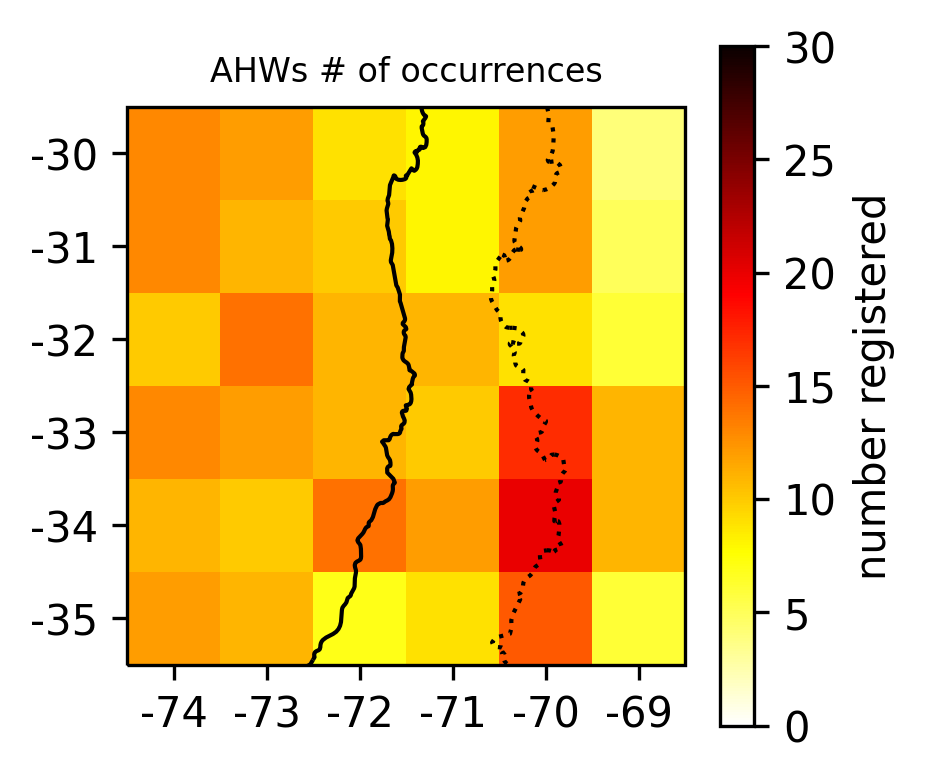

In [16]:
# plot the number of HWs recorded at each grid cell
plt.figure(dpi=300, figsize=(3,3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
#ax.add_feature(cartopy.feature.OCEAN, facecolor=("lightblue"))
#ax.add_feature(cartopy.feature.LAND)
plt.title('AHWs # of occurrences', fontsize=8)
plt.pcolormesh(lon, lat, storeHWcount, cmap='hot_r')
plt.colorbar(label='number registered')
plt.clim([0,30])
ax.set_xticks([-74, -73, -72, -71, -70, -69], crs=ccrs.PlateCarree())
ax.set_xticklabels([-74, -73, -72, -71, -70, -69])
ax.set_yticks([-30, -31, -32, -33, -34, -35], crs=ccrs.PlateCarree())
ax.set_yticklabels([-30, -31, -32, -33, -34, -35])